# Solving differential equations with dCGP

Lets first import dcgpy and pyaudi and set up things as to use dCGP on gduals defined over floats

In [22]:
from dcgpy import expression_gdual_vdouble as expression
from dcgpy import kernel_set_gdual_vdouble as kernel_set
from pyaudi import gdual_vdouble as gdual
from matplotlib import pyplot as plt
import numpy as np
from numpy import sin, cos
from random import randint
np.seterr(all='ignore') # avoids numpy complaining about early on malformed expressions being evalkuated
%matplotlib inline

## 1 - We define the set of kernel functions we will be using

In [23]:
kernels = kernel_set(["sum", "diff", "div", "mul", "log", "sin", "cos", "exp"])() # note the call operator (returns the list of kernels)

## 2 - We instantiate a dCGP and we inspect a randomly created program

In [24]:
dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = 13)

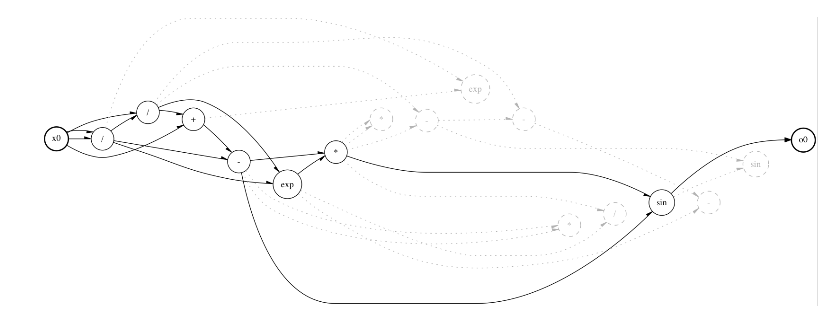

Represented expression:  sin(((x/x)-(x+(x/(x/x)))))
Simplified expression:  -sin(2*x - 1)


In [25]:
plt.rcParams["figure.figsize"] = [10,6]
dCGP.visualize() #requires pygraphwiz module installed
print("Represented expression: ", dCGP(["x"])[0])
print("Simplified expression: ", dCGP.simplify(["x"])) #requires sympy module installed

# 3 - We define the ES that will evolve solutions

In [62]:
# We run an evolutionary strategy ES(1 + offspring)
def run_experiment(max_gen, offsprings, quadratic_error, initial_conditions_error, screen_output=False):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    chromosome = [1] * offsprings
    fitness = [1] *offsprings
    best_chromosome = dCGP.get()
    best_fitness = quadratic_error(dCGP, grid) + initial_conditions_error(dCGP)
    for g in range(max_gen):
        for i in range(offsprings):
            dCGP.set(best_chromosome)
            dCGP.mutate_active(i) #  we mutate a number of increasingly higher active genes
            qe = quadratic_error(dCGP, grid)
            ie = initial_conditions_error(dCGP)
            fitness[i] = ie + qe
            chromosome[i] = dCGP.get()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                if (fitness[i] != best_fitness) and screen_output:
                    print("New best found: gen: ", g, " value: ", fitness[i])
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
                dCGP.set(best_chromosome)
        if best_fitness < 1e-7:
            break
    return g, best_chromosome

## 4 - We consider the following Ordinary Differential Equation (ODE1):

$\frac{dy}{dx} = \frac{2x - y}{x}$, with $y(0.1) = 20.1$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

The solution to the ODE is $y = x + \frac 2x$

In [27]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE1(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode1 = (2. * x - y) / x
    retval += (ode1 - dydx) * (ode1 - dydx)
    return sum(retval)

In [28]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE1(dCGP):
    x0 = 1
    y0 = 3
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [29]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [30]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
offsprings = 10
stop = 400
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = 400, offsprings = offsprings, \
            quadratic_error=qe_ODE1, initial_conditions_error=ic_ODE1)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
2 		 285 	 ['((((x+x)/x)/x)+x)']  a.k.a  x + 2/x
5 		 31 	 ['(((x/x)*x)+((exp(log((x/x)))+exp(log((x/x))))/(x*exp(log((x/x))))))']  a.k.a  x + 2/x
6 		 351 	 ['(x+((((x/x)*(x/x))+(x/x))/x))']  a.k.a  x + 2/x
7 		 271 	 ['(((x+x)/(x*x))+x)']  a.k.a  x + 2/x
8 		 110 	 ['((((x/x)*((x/x)+(x/x)))/x)+x)']  a.k.a  x + 2/x
9 		 210 	 ['(x+((x+x)/(x*x)))']  a.k.a  x + 2/x
13 		 129 	 ['(((x/x)/x)+(cos((x-x))*(((x/x)/x)+x)))']  a.k.a  x + 2/x
14 		 131 	 ['((((x/x)/x)+((x/x)/x))+x)']  a.k.a  x + 2/x
20 		 98 	 ['((((x*x)*(x+x))/((x*x)*(x*x)))+x)']  a.k.a  x + 2/x
21 		 364 	 ['(((((x/x)/(x/x))/x)+(((x/x)/(x/x))/x))+x)']  a.k.a  x + 2/x
24 		 105 	 ['((x+(x/(x*x)))+(x/(x*x)))']  a.k.a  x + 2/x
28 		 123 	 ['(((x/(x/x))+((x/x)/x))+((x/x)/x))']  a.k.a  x + 2/x
30 		 245 	 ['(x+(((x/x)+(x/x))/((x/x)*x)))']  a.k.a  x + 2/x
32 		 95 	 ['(((x*x)/x)+((x+((x*x)/x))/(x*x)))']  a.k.a  x + 2/x
33 		 262 	 ['((((((x/x)-sin((x/x)))+(x/x))+sin((x/x)))/x)+log(exp(x)))']  a.k.a  lo

In [33]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 653 * 200)

ERT Expected run time - avg. number of function evaluations needed:  11683.4482759
Avg. number of function evaluations from Tsoulos paper:  130600


## 5 - We consider the following Ordinary Differential Equation (ODE2):

$\frac{dy}{dx} = \frac{1 - ycos(x)}{sin(x)}$, with $y(0.1) = \frac{2.1}{sin(0,1)}$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = \frac{x+2}{sin(x)}$

In [36]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [34]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE2(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode2 = (1. -  y * cos(x)) / sin(x)
    retval += (ode2 - dydx) * (ode2 - dydx)
    return sum(retval)

In [35]:
# We define a penalty term associated to the initial conditions violation
dummy = (2.1)/sin(0.1)
def ic_ODE2(dCGP):
    x0 = 0.1
    y0 = dummy
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [43]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = 400, offsprings = offsprings, \
            quadratic_error=qe_ODE2, initial_conditions_error=ic_ODE2)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
5 		 60 	 ['(((x/x)+((x/x)+x))/sin(x))']  a.k.a  x/sin(x) + 2/sin(x)
7 		 50 	 ['((x+((sin(x)+sin(x))/sin(x)))/sin(x))']  a.k.a  x/sin(x) + 2/sin(x)
18 		 149 	 ['(((x*(x/x))+((x/x)+(x/x)))/sin((x*(x/x))))']  a.k.a  x/sin(x) + 2/sin(x)
27 		 52 	 ['((x+((x/x)+(x/x)))/sin(x))']  a.k.a  x/sin(x) + 2/sin(x)
38 		 193 	 ['(((x/sin(x))+((x/sin(x))/x))+((x/sin(x))/x))']  a.k.a  x/sin(x) + 2/sin(x)
45 		 173 	 ['((((x/x)+(x/x))+x)/sin(x))']  a.k.a  x/sin(x) + 2/sin(x)
68 		 121 	 ['(((((x/x)/sin(x))*x)+((x/x)/sin(x)))+((x/x)/sin(x)))']  a.k.a  x/sin(x) + 2/sin(x)
81 		 381 	 ['(((sin(x)+(((x*sin(x))/x)+(x*sin(x))))/sin(x))/sin(x))']  a.k.a  x/sin(x) + 2/sin(x)


In [44]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 742 * 200)

ERT Expected run time - avg. number of function evaluations needed:  94717.5
Avg. number of function evaluations from Tsoulos paper:  148400


## 6 - We consider the following Ordinary Differential Equation (ODE5):

$\frac{d^2y}{dx^2} = 6\frac{dy}{dx} - 9y$, with $y(0) = 0$, $\frac{dy}{dx}(0)=2$ and $x \in [0,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = 2x \exp(3x)$

In [69]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0,1,10)
grid = gdual(values, "x", 2)

In [70]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE5(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    ode5 = 6. * dydx - 9 * y
    retval += (ode5 - dydx2) * (ode5 - dydx2)
    return sum(retval)

In [127]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE5(dCGP):
    x0 = 1e-16 # avoids what seems a numerical problem with vectorized dual?
    y0 = 0.
    dy0 = 2.
    out = dCGP([gdual([x0], "x", 1)])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0) + (dCGP_dy0 - dy0) * (dCGP_dy0 - dy0)

In [129]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = 400, offsprings = offsprings, \
            quadratic_error=qe_ODE5, initial_conditions_error=ic_ODE5)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
3 		 117 	 ['(exp((x+x))*((x+x)/((x*x)/(exp(x)*(x*x)))))']  a.k.a  2*x*exp(3*x)
4 		 260 	 ['(exp((x+(x+x)))*(x+x))']  a.k.a  2*x*exp(3*x)
9 		 301 	 ['((x+x)*exp((x+(x+x))))']  a.k.a  2*x*exp(3*x)
10 		 344 	 ['(((exp(x)*exp(x))+(exp(x)*exp(x)))*(x*exp(x)))']  a.k.a  2*x*exp(3*x)
14 		 309 	 ['(exp(((x+x)+x))*(((x+x)+x)-x))']  a.k.a  2*x*exp(3*x)
15 		 261 	 ['(exp(x)*(((x+x)*exp(x))*exp(x)))']  a.k.a  2*x*exp(3*x)
17 		 325 	 ['(exp(((x+log(exp(x)))+x))*(x+log(exp(x))))']  a.k.a  x*exp(3*x) + exp(3*x)*log(exp(x))
26 		 355 	 ['((x+(x-(x-x)))*exp((x+(x+(x-(x-x))))))']  a.k.a  2*x*exp(3*x)
35 		 248 	 ['(exp(((x+x)+x))*(x+x))']  a.k.a  2*x*exp(3*x)
37 		 193 	 ['((x+x)*exp((x+(x+x))))']  a.k.a  2*x*exp(3*x)
45 		 305 	 ['(exp(((x+x)+x))*(x+x))']  a.k.a  2*x*exp(3*x)
48 		 273 	 ['((exp(x)*((exp(x)+(exp(x)-exp(x)))*(exp(x)+exp(x))))*(x+(exp(x)-exp(x))))']  a.k.a  2*x*exp(3*x)
53 		 287 	 ['((x+x)*exp(((x+x)+x)))']  a.k.a  2*x*exp(3*x)
59 		 297 	 ['(exp((x+

In [131]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 441 * 200)

ERT Expected run time - avg. number of function evaluations needed:  15478.75
Avg. number of function evaluations from Tsoulos paper:  88200


## 7 - We consider the following non linear Ordinary Differential Equation (NLODE3):

$\frac{d^2y}{dx^2}\frac{dy}{dx} = -\frac4{x^3}$, with $y(1) = 0$, and $x \in [1,2]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = log(x^2)$

In [133]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(1,2,10)
grid = gdual(values, "x", 2)

In [134]:
# We define the quadratic error of the dCGP in the grid points
def qe_NLODE3(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    nlode3 = dydx2*dydx
    retval += (nlode3 + 4/x/x/x) * (nlode3 + 4/x/x/x)
    return sum(retval)

In [135]:
# We define a penalty term associated to the initial conditions violation
def ic_NLODE3(dCGP):
    x0 = 1 # avoids what seems a numerical problem with vectorized dual?
    y0 = 0.
    out = dCGP([gdual([x0])])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0)

In [136]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = 400, offsprings = offsprings, \
            quadratic_error=qe_NLODE3, initial_conditions_error=ic_NLODE3)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 210 	 ['log(log(exp((x*x))))']  a.k.a  log(log(exp(x**2)))
2 		 8 	 ['((log(x)/(x/x))+log(x))']  a.k.a  2*log(x)
3 		 9 	 ['(log(x)+log(x))']  a.k.a  2*log(x)
4 		 4 	 ['log((x*x))']  a.k.a  log(x**2)
5 		 5 	 ['(((x*x)/(x*x))+(log((x*x))-((x*x)/(x*x))))']  a.k.a  log(x**2)
6 		 35 	 ['(log(x)+log(x))']  a.k.a  2*log(x)
7 		 258 	 ['(log(x)+log(x))']  a.k.a  2*log(x)
8 		 3 	 ['log((x*x))']  a.k.a  log(x**2)
9 		 6 	 ['(log(x)+log(x))']  a.k.a  2*log(x)
11 		 33 	 ['log((x*x))']  a.k.a  log(x**2)
12 		 24 	 ['(log(x)+log(x))']  a.k.a  2*log(x)
13 		 46 	 ['log((x*x))']  a.k.a  log(x**2)
14 		 2 	 ['(log(x)+log(x))']  a.k.a  2*log(x)
15 		 46 	 ['log(((x+(x*x))-x))']  a.k.a  log(x**2)
16 		 9 	 ['(log(x)+(log(x)+sin(((x-x)/(x-x)))))']  a.k.a  nan
17 		 12 	 ['(log(x)+log((exp(x)+(x-exp(x)))))']  a.k.a  2*log(x)
19 		 3 	 ['log((x*x))']  a.k.a  log(x**2)
20 		 0 	 ['(log(x)+log(x))']  a.k.a  2*log(x)
21 		 25 	 ['log((x*(x-(x-x))))']  a.k.a  log(x**2)
2

In [138]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 191 * 200)

ERT Expected run time - avg. number of function evaluations needed:  710.0
Avg. number of function evaluations from Tsoulos paper:  38200
